# Imports

In [151]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score

In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# change directory to the folder where the data is stored
%cd /content/drive/My Drive/SAT/project

Mounted at /content/drive
/content/drive/My Drive/SAT/project


# Helpers

In [ ]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [ ]:
def extract_file(zip_path,specified_directory):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(specified_directory)

In [ ]:
def read_images(flooded_path,non_flooded_path,width,height):
    flooded = np.empty((0, width, height, 3))
    non_flooded = np.empty((0, width, height, 3))

    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0)
        flooded = np.concatenate((flooded, img), axis=0)

    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0  
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [ ]:
def show_images(images,images_labels):
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

# Images reading

In [ ]:
# extract_file("./dataset.zip","./dataset")

In [ ]:
flooded,non_flooded=read_images("dataset/dataset/flooded","dataset/dataset/non-flooded", 256, 256)
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (461, 256, 256, 3)
non_flooded images shapes (461, 256, 256, 3)


In [122]:
from scipy import signal
def preprocess_img(img):

  # Apply one iteration of erosion
  img = cv2.erode(img, np.ones((5, 5)), iterations=1)

  # Apply two iterations of dilation
  img_dilated = cv2.dilate(img, np.ones((5, 5)), iterations=1)

  return img

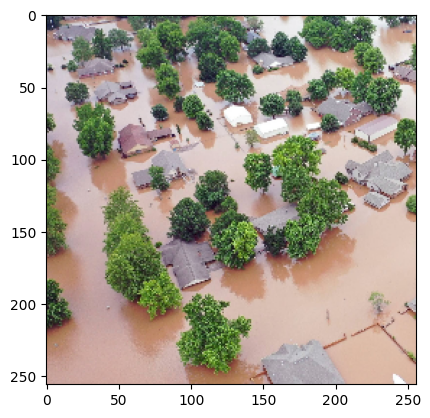

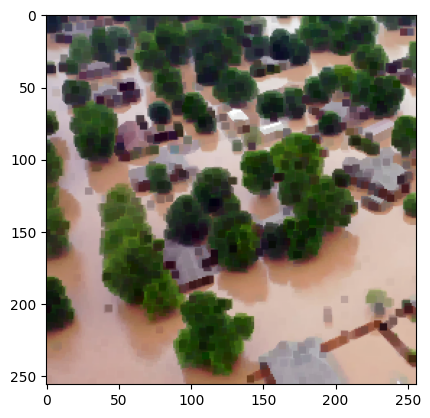

In [123]:
img = flooded[0].astype('float32')
show_img(img)
show_img(preprocess_img(img))

In [158]:
def segment_img(img, min_clusters=2, max_clusters=5):

  # apply image preprocessing
  img_arr = np.array(preprocess_img(img))
  # img_arr = np.array(img)

  # Reshape the image array to a 2D array of pixels
  img_pixels = img_arr.reshape(-1, 3)

  # Scale the pixel values to improve the clustering performance
  scaler = StandardScaler()
  img_pixels_scaled = scaler.fit_transform(img_pixels)

  best_ch_score = 0
  best_cluster_labels = None
  best_n_clusters = 0
  for k in range(min_clusters, max_clusters+1):

    # Initialize the k-means algorithm
    kmeans = KMeans(n_clusters=k, n_init='auto')

    # Fit the algorithm to the data
    kmeans.fit(img_pixels_scaled)

    # Get the cluster labels for each pixel
    cluster_labels = kmeans.labels_

    # Compute the Calinski-Harabasz index for the clustering solution
    ch_score = calinski_harabasz_score(img_pixels_scaled, cluster_labels)

    # save best result
    if ch_score > best_ch_score:
      best_ch_score = ch_score
      best_cluster_labels = cluster_labels
      best_n_clusters = k
    
  # Print the best Calinski-Harabasz score
  print("The best Calinski-Harabasz score is:", best_ch_score)

  # Print the best n_clusters
  print("The best n_clusters is:", best_n_clusters)

  # Reshape the cluster labels to the original image shape
  clustered_img = best_cluster_labels.reshape(img_arr.shape[:2])

  # Visualize the original image and the clustered image
  fig, ax = plt.subplots(1, 3)
  ax[0].imshow(img)
  ax[0].set_title('Original Image')
  ax[1].imshow(img_arr)
  ax[1].set_title('Preprocessed Image')
  ax[2].imshow(clustered_img)
  ax[2].set_title('Clustered Image')
  plt.show()


The best Calinski-Harabasz score is: 256289.87734606586
The best n_clusters is: 3


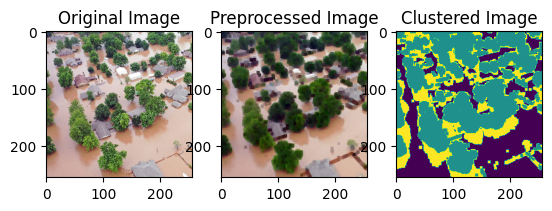

The best Calinski-Harabasz score is: 120904.54906970663
The best n_clusters is: 4


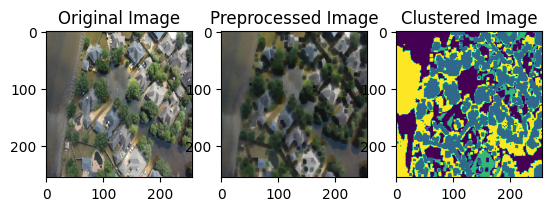

The best Calinski-Harabasz score is: 178941.6817922648
The best n_clusters is: 5


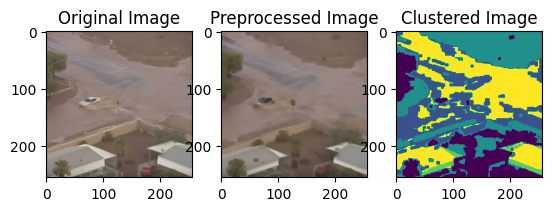

The best Calinski-Harabasz score is: 203991.04987394292
The best n_clusters is: 2


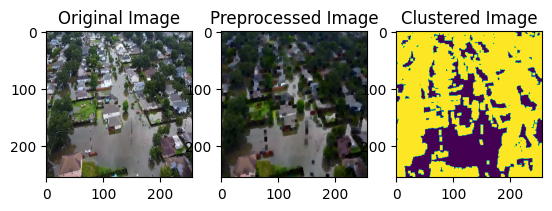

The best Calinski-Harabasz score is: 163405.98620248036
The best n_clusters is: 4


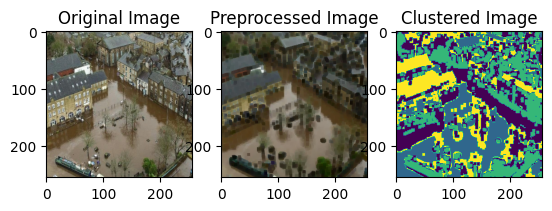

The best Calinski-Harabasz score is: 227936.69513077047
The best n_clusters is: 2


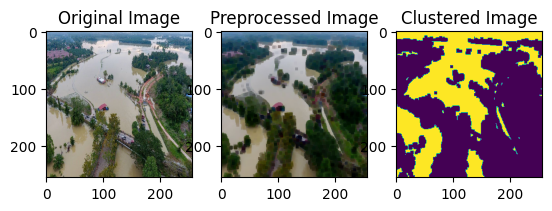

The best Calinski-Harabasz score is: 91697.62801329458
The best n_clusters is: 5


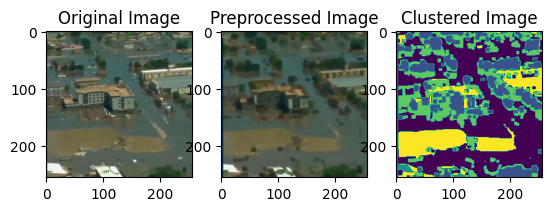

The best Calinski-Harabasz score is: 314572.2056755945
The best n_clusters is: 5


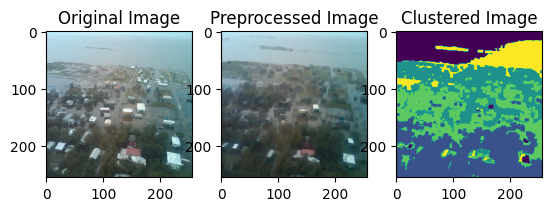

The best Calinski-Harabasz score is: 186580.6775934821
The best n_clusters is: 5


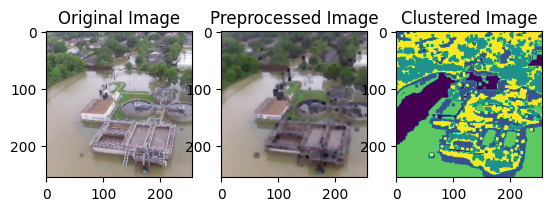

The best Calinski-Harabasz score is: 119368.56839342434
The best n_clusters is: 4


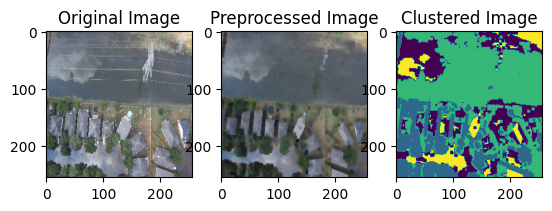

In [159]:
for i in range(10):
  segment_img(flooded[i])